In [319]:
import pandas as pd
import numpy as np
from scalecast.Forecaster import Forecaster
from scalecast.auxmodels import auto_arima
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(14,7)})

In [320]:
df = pd.read_csv('Corptax_all.csv')
df[['Date Closed','Date Created']] = df[['Date Closed','Date Created']].apply(pd.to_datetime, errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190892 entries, 0 to 190891
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Unnamed: 0         190892 non-null  int64         
 1   index              190892 non-null  int64         
 2   Case Number        190892 non-null  int64         
 3   Subject            190891 non-null  object        
 4   Date Created       190892 non-null  datetime64[ns]
 5   Date Closed        190772 non-null  datetime64[ns]
 6   Origin             190892 non-null  object        
 7   Priority           190892 non-null  object        
 8   Team               190890 non-null  object        
 9   Case Type          187269 non-null  object        
 10  SLA                190843 non-null  object        
 11  Problem Statement  187361 non-null  object        
 12  Product            190765 non-null  object        
 13  Product Area       190672 non-null  object  

In [321]:
fill_dt = pd.Timestamp.now().normalize()
df['Date Closed'] = df['Date Closed'].fillna(fill_dt)

In [322]:
df.isna().sum()

Unnamed: 0                0
index                     0
Case Number               0
Subject                   1
Date Created              0
Date Closed               0
Origin                    0
Priority                  0
Team                      2
Case Type              3623
SLA                      49
Problem Statement      3531
Product                 127
Product Area            220
Product Category     143167
Product Type         185713
Jurisdiction          67731
Resolution             3119
KB #                 138592
KB Title             140655
dtype: int64

In [323]:
df = df.dropna(axis=0, subset=['Product', 'Product Area'])

In [324]:
df.isna().sum()

Unnamed: 0                0
index                     0
Case Number               0
Subject                   1
Date Created              0
Date Closed               0
Origin                    0
Priority                  0
Team                      2
Case Type              3610
SLA                      47
Problem Statement      3522
Product                   0
Product Area              0
Product Category     142947
Product Type         185493
Jurisdiction          67618
Resolution             3109
KB #                 138420
KB Title             140483
dtype: int64

In [325]:
df['Year']= df['Date Created'].dt.year
df['Month']= df['Date Created'].dt.month
df['Week']= df['Date Created'].dt.isocalendar().week
df['week_num'] = df['Week'] + (df['Year'] - df['Year'].min())*52

In [336]:
df['Date'] = df['Date Created'].dt.date 
drop_columns = ['Date Closed','Date Created','Unnamed: 0',]
df.drop(drop_columns, axis=1, inplace=True)
df.head()

KeyError: 'Date Created'

In [327]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d')

In [328]:
df.rename(columns={'Case Number':'Case_Number', 'Product Area': 'Product_Area'}, inplace=True)

In [329]:
df['PPA'] = df['Product'] + " : " + df['Product_Area']
df.head()

,index,Case_Number,Subject,Origin,Priority,Team,Case Type,SLA,Problem Statement,Product,Product_Area,Product Category,Product Type,Jurisdiction,Resolution,KB #,KB Title,Year,Month,Week,week_num,Date,PPA
0,0,204977,Efile Acceptance,Web,Medium,Tax Preparation,Efile,Platinum,We transmitted a Michigan return still have not received the acceptance/rejection confirmation.,Compliance,Returns / Reports,NaN,NaN,US.MI,Answer exists KB,041324813494120,How to understand the Transmission Monitor,2017,1,1,1,2017-01-02,Compliance : Returns / Reports
1,1,204979,Oregon STAT help: Previous Case 203787 Client needs help after 4pm CST today,Web,High,Tax Preparation,Question / How To,Silver,Oregon STAT help: Previous Case 203787 Client needs help after 4pm CST today,Provision,State,NaN,NaN,US.OR,Customer no longer needs assistance,NaN,NaN,2017,1,1,1,2017-01-02,Provision : State
2,2,204980,Data map incorrectly pulling in values,Web,Medium,Tax Preparation,Question / How To,Silver,Corptax Office Import - Credit Account imports are not posting as expected,Office - Excel Add-In,Import / Export,NaN,NaN,US,Answer exists KB,041414821333274,Corptax® Office - How to place an IF formula in the Advanced formula setting of the Data Templat...,2017,1,1,1,2017-01-02,Office - Excel Add-In : Import / Export
3,3,204981,The New Corptax Connect Website is not properly working,Web,High,Tax Preparation,Problem / Error,Silver,Searches can't be performed on the new system. It hasn't functioned properly since the change. ...,Websites,Connections (https://connect.corptax.com),Error Message,NaN,NaN,Answer exists KB,161216104028927,Connections Error - Uh Oh something went wrong while loading this page,2017,1,1,1,2017-01-02,Websites : Connections (https://connect.corptax.com)
4,4,204986,LD400 is not reflecting a temporary adjustment,E-mail,Medium,Tax Preparation,Problem / Error,Platinum,LD400 is not reflecting a temporary adjustment,Compliance,Returns / Reports,NaN,NaN,US,Answer exists KB,041622907012748,Adjustments do not flow to LD400 workpaper and Taxable income per the LD400 does not tie to the ...,2017,1,1,1,2017-01-03,Compliance : Returns / Reports


In [339]:
df.PPA.nunique()

113

In [340]:
filter = ['Compliance', 'International (US)','Office - Excel Add-In','Provision','Partnership / S Corp / Pass-Through']
df1 =  df[df['Product'].isin(filter)]
df1.head()

,index,Case_Number,Subject,Origin,Priority,Team,Case Type,SLA,Problem Statement,Product,Product_Area,Product Category,Product Type,Jurisdiction,Resolution,KB #,KB Title,Year,Month,Week,week_num,Date,PPA
0,0,204977,Efile Acceptance,Web,Medium,Tax Preparation,Efile,Platinum,We transmitted a Michigan return still have not received the acceptance/rejection confirmation.,Compliance,Returns / Reports,NaN,NaN,US.MI,Answer exists KB,041324813494120,How to understand the Transmission Monitor,2017,1,1,1,2017-01-02,Compliance : Returns / Reports
1,1,204979,Oregon STAT help: Previous Case 203787 Client needs help after 4pm CST today,Web,High,Tax Preparation,Question / How To,Silver,Oregon STAT help: Previous Case 203787 Client needs help after 4pm CST today,Provision,State,NaN,NaN,US.OR,Customer no longer needs assistance,NaN,NaN,2017,1,1,1,2017-01-02,Provision : State
2,2,204980,Data map incorrectly pulling in values,Web,Medium,Tax Preparation,Question / How To,Silver,Corptax Office Import - Credit Account imports are not posting as expected,Office - Excel Add-In,Import / Export,NaN,NaN,US,Answer exists KB,041414821333274,Corptax® Office - How to place an IF formula in the Advanced formula setting of the Data Templat...,2017,1,1,1,2017-01-02,Office - Excel Add-In : Import / Export
4,4,204986,LD400 is not reflecting a temporary adjustment,E-mail,Medium,Tax Preparation,Problem / Error,Platinum,LD400 is not reflecting a temporary adjustment,Compliance,Returns / Reports,NaN,NaN,US,Answer exists KB,041622907012748,Adjustments do not flow to LD400 workpaper and Taxable income per the LD400 does not tie to the ...,2017,1,1,1,2017-01-03,Compliance : Returns / Reports
6,6,204992,Form 2220 Line 19 dates.,Web,Medium,Tax Preparation,Problem / Error,Platinum,Form 2220 Line 19 dates are repeating. This is a fiscal year client and the quarterly date for p...,Compliance,Amounts,NaN,NaN,US,Answer exists KB,041335414275440,IRS e-Services and Business MeF Maintenance including states,2017,1,1,1,2017-01-03,Compliance : Amounts


In [341]:
df1.PPA.value_counts()

Compliance : Returns / Reports                             77888
International (US) : Returns / Reports                     14589
Compliance : Amounts                                        8515
Compliance : Install / Rollover                             7121
Compliance : Configuration / Setup                          5964
Partnership / S Corp / Pass-Through : Returns / Reports     5927
International (US) : Foreign Processing                     5461
Provision : Federal                                         4489
Compliance : Import / Export                                3299
Compliance : Environment Maintenance                        3187
International (US) : Tax Cuts and Jobs Act                  3089
International (US) : Calculation / Posting                  3041
Provision : Configuration / Setup                           2787
Provision : State                                           1901
International (US) : Configuration / Setup                  1673
Compliance : BEPS CbC    

In [342]:
len(df1.PPA.value_counts())

54

In [343]:
list(df1.PPA.value_counts()[df1.PPA.value_counts() > 1600].index)

['Compliance : Returns / Reports',
 'International (US) : Returns / Reports',
 'Compliance : Amounts',
 'Compliance : Install / Rollover',
 'Compliance : Configuration / Setup',
 'Partnership / S Corp / Pass-Through : Returns / Reports',
 'International (US) : Foreign Processing',
 'Provision : Federal',
 'Compliance : Import / Export',
 'Compliance : Environment Maintenance',
 'International (US) : Tax Cuts and Jobs Act',
 'International (US) : Calculation / Posting',
 'Provision : Configuration / Setup',
 'Provision : State',
 'International (US) : Configuration / Setup']

Compliance : Returns / Reports
length of dataframe :  68
the series is not stationary
Lets Make Data Stationary First
Now, This series is stationary
============================END=================================
International (US) : Returns / Reports
length of dataframe :  68
the series is not stationary
Lets Make Data Stationary First
Now, This series is stationary
============================END=================================
Compliance : Amounts
length of dataframe :  68
the series is not stationary
Lets Make Data Stationary First
Now, This series is stationary
============================END=================================
Compliance : Install / Rollover
length of dataframe :  68
the series is not stationary
Lets Make Data Stationary First
Now, This series is stationary
============================END=================================
Compliance : Configuration / Setup
length of dataframe :  68
the series is not stationary
Lets Make Data Stationary First
Now, This series is sta

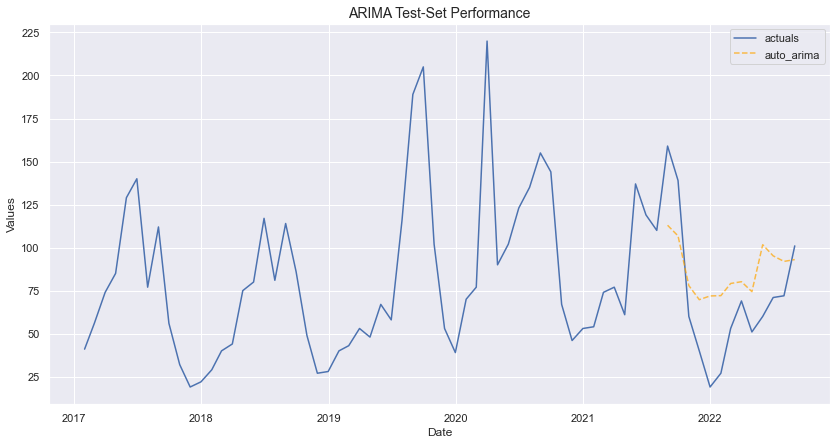

============================END=================================
Provision : Federal
length of dataframe :  68
the series is not stationary
Lets Make Data Stationary First
Now, This series is stationary
============================END=================================
Compliance : Import / Export
length of dataframe :  68
the series is not stationary
Lets Make Data Stationary First
Now, This series is stationary
============================END=================================
Compliance : Environment Maintenance
length of dataframe :  68
the series is stationary
Performing stepwise search to minimize aic
 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=604.813, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=600.383, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=599.497, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=598.973, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=632.326, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=602.046, Time=0.

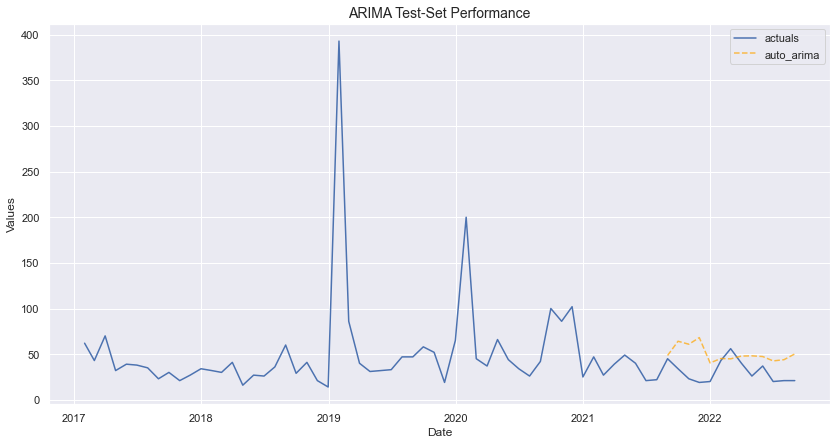

============================END=================================
International (US) : Tax Cuts and Jobs Act
length of dataframe :  54
the series is not stationary
Lets Make Data Stationary First
Now, This series is not stationary
============================END=================================
International (US) : Calculation / Posting
length of dataframe :  68
the series is stationary
Performing stepwise search to minimize aic
 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=541.391, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=516.375, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=519.885, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=600.351, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=521.272, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=517.178, Time=0.23 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=515.305, Time=0.21 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=5

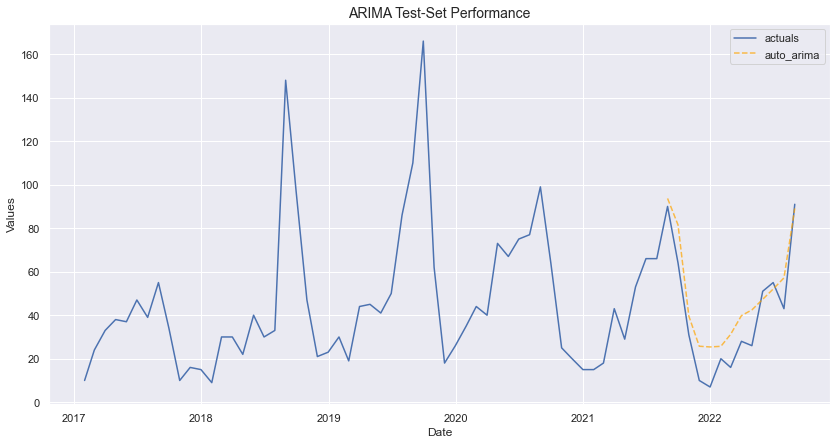

============================END=================================
Provision : Configuration / Setup
length of dataframe :  68
the series is stationary
Performing stepwise search to minimize aic
 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=471.608, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=455.152, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=461.200, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=579.261, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=461.810, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=445.950, Time=0.22 sec
 ARIMA(1,0,0)(3,0,0)[12] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=446.631, Time=0.47 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=448.755, Time=0.26 sec
 ARIMA(1,0,0)(3,0,1)[12] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=451.215, Time=0.28 sec
 ARIMA(2,0,0)(2,0,0)[12] in

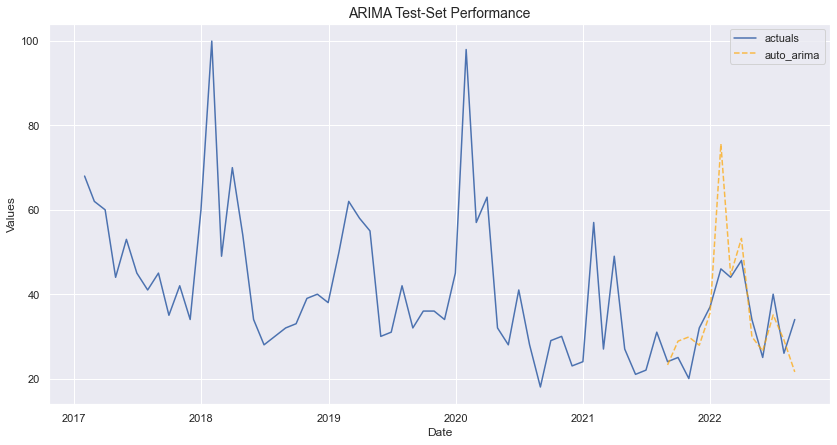

============================END=================================
Provision : State
length of dataframe :  68
the series is not stationary
Lets Make Data Stationary First
Now, This series is stationary
============================END=================================
International (US) : Configuration / Setup
length of dataframe :  68
the series is stationary
Performing stepwise search to minimize aic
 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=404.608, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=417.219, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=408.823, Time=0.06 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=408.243, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=523.172, Time=0.00 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=413.150, Time=0.16 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=409.726, Time=0.30 sec
 ARIMA(2,0,1)(2,0,1)[12] intercept   : AIC=399.878, Time=0.62 sec
 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=402.013, Time=0.55 sec
 AR

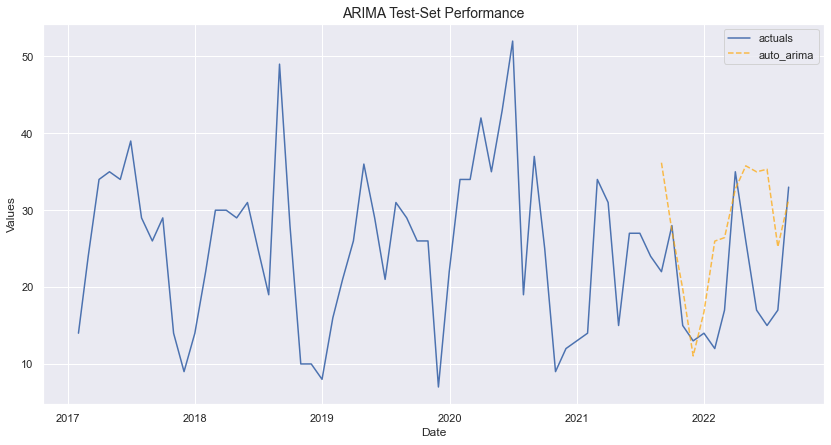

============================END=================================


In [334]:
res = {}
for i in list(df1.PPA.value_counts()[df1.PPA.value_counts() > 1600].index):
    train_rmse = []
    test_rmse = []
    months = []
    print(i)
    
    #grouping by month
    temp = df1[df1.PPA == i][["Case_Number","Date"]]
    newdf = pd.DataFrame(temp.groupby([temp["Date"].dt.date]).count()["Case_Number"])
    newdf = newdf.reset_index()
    newdf.index = newdf.Date
    newdf['Date'] = pd.to_datetime(newdf['Date'], errors='coerce')
    newdf = newdf.asfreq('D')
    newdf = newdf.groupby(pd.Grouper(freq="M")).sum()
    
    
    print("length of dataframe : ",newdf.shape[0])
    f = Forecaster(y=newdf['Case_Number'],current_dates=newdf.index)
    f.generate_future_dates(12)
    f.set_test_length(.2)
    critical_pval = 0.05
    stat, pval, _, _, _, _ = f.adf_test(full_res=True)
    print('the series is {}'.format('stationary' if pval < critical_pval else 'not stationary'))
    if pval < critical_pval:
        auto_arima(
            f,
            start_P=1,
            start_q=1,
            max_p=10,
            max_q=10,
            m=12,
            seasonal=True,
            max_P=10, 
            max_D=10,
            max_Q=10,
            max_d=10,
            trace=True,
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True,
            information_criterion="aic",
            alpha=0.05,
            scoring='mse',
            call_me='auto_arima',)
        f.plot_test_set(ci=False,models='auto_arima')
        plt.title('ARIMA Test-Set Performance',size=14)
        plt.show()
        results = f.export(to_excel=True,excel_name='mlr.xlsx')
        train_rmse.append(round(results["model_summaries"]["InSampleRMSE"][0],2))
        test_rmse.append(round(results["model_summaries"]["TestSetRMSE"][0],2))
        
        for j in range(0,4):
            months.append(round(results["lvl_fcsts"].iloc[j]["auto_arima"]))
        model = "arima-S"
        res[i] = [model, train_rmse[0], test_rmse[0], newdf.min()[0], newdf.max()[0], newdf.mean()[0], newdf.std()[0],months[0],months[1],months[2],months[3]]

    else:
        print("Lets Make Data Stationary First")
        f.set_estimator('mlr')
        f.add_ar_terms(12) 
        f.add_seasonal_regressors('quarter',dummy=True) # 2.
        f.add_time_trend() # 2.
        f.diff()
        stat, pval, _, _, _, _ = f.adf_test(full_res=True)
        print('Now, This series is {}'.format('stationary' if pval < critical_pval else 'not stationary'))
        f.manual_forecast()
        results = f.export(to_excel=True,
                   excel_name='mlr.xlsx')
        train_rmse.append(round(results["model_summaries"]["InSampleRMSE"][0],2))
        test_rmse.append(round(results["model_summaries"]["TestSetRMSE"][0],2))
        
        for j in range(0,4):
            months.append(round(results["lvl_fcsts"].iloc[j]["mlr"]))
            
        model = "mlr-NS"
        res[i] = [model, train_rmse[0], test_rmse[0], newdf.min()[0], newdf.max()[0], newdf.mean()[0], newdf.std()[0],months[0],months[1],months[2],months[3]]
    print("============================END=================================")


In [338]:
ind = ["model","train_rmse","test_rmse","min", "max", "mean", "std", "sept", "oct", "nov", "dec"]
res_df = pd.DataFrame(res)
res_df.index = ind
round(res_df,2).T.to_csv("all_mods.csv")

In [291]:
res_df

,Compliance : Returns / Reports,International (US) : Returns / Reports,Compliance : Amounts,Compliance : Install / Rollover,Compliance : Configuration / Setup,International (US) : Foreign Processing,Provision : Federal,Compliance : Import / Export,Compliance : Environment Maintenance,International (US) : Tax Cuts and Jobs Act,International (US) : Calculation / Posting,Provision : Configuration / Setup,Provision : State,International (US) : Configuration / Setup
model,mlr,mlr,mlr,mlr,mlr,arima-S,mlr,mlr,arima-S,mlr,arima-S,arima-S,mlr,arima-S
train_rmse,293.46,56.09,20.93,28.99,13.82,32.71,13.98,9.0,47.74,12.39,21.69,11.99,6.95,8.14
test_rmse,254.61,69.47,28.7,54.25,10.73,32.03,12.44,10.06,24.59,13.23,12.03,9.78,10.28,10.48
min,456.0,44.0,33.0,30.0,42.0,19.0,24.0,11.0,14.0,0.0,7.0,18.0,5.0,7.0
max,4449.0,684.0,352.0,280.0,164.0,220.0,247.0,110.0,393.0,334.0,166.0,100.0,79.0,52.0
mean,1145.411765,214.544118,125.220588,104.720588,87.705882,80.308824,66.014706,48.514706,46.867647,57.203704,44.720588,40.985294,27.955882,24.602941
std,799.908021,149.335387,76.434704,67.240012,26.948851,44.954789,36.106597,22.153126,50.457875,72.929374,31.394859,16.28798,15.411213,10.16159
sept,1496,489,208,78,74,97,51,32,38,18,78,32,30,27
oct,2107,241,234,75,44,67,50,9,36,18,37,31,33,20
nov,1006,99,134,42,30,61,44,7,33,16,21,30,27,14
